# Interactions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set()

## Building an Interaction

### 7.1

In [4]:
d = pd.read_csv('Data/rugged.csv', sep=';')

# make log version of outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d[np.isfinite(d["rgdppc_2000"])]

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]
d_A0 = dd[dd["cont_africa"] == 0]

### 7.2

In [5]:
# African Nations
with pm.Model() as m7_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A1["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A1["log_gdp"])
    trace7_1 = pm.sample(draws=1000, tune=1000)
    
# non-African Nations
with pm.Model() as m7_2:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A0["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A0["log_gdp"])
    trace7_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1030.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 572.50draws/s]


### 7.3

In [6]:
model_rugged = theano.shared(dd["rugged"].values)
model_cont_africa = theano.shared(dd["cont_africa"].values)

In [7]:
with pm.Model() as m7_3:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 719.54draws/s]


### 7.4

In [8]:
with pm.Model() as m7_4:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 655.62draws/s]


### 7.5

In [9]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_4,475.79,4.03,0,1,14.86,0,1
m7_3,539.33,2.51,63.54,0,12.9,14.64,0


### 7.6

In [10]:
rugged_seq = np.arange(-8, 8, 0.25)
model_rugged.set_value(rugged_seq)

# compute mu over samples, fixing cont_africa=0
model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]

# compute mu over samples, fixing cont_africa=1
model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]


mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

100%|██████████| 10000/10000 [00:01<00:00, 5760.15it/s]


### 7.7

In [11]:
model_rugged.set_value(dd["rugged"].values)
model_cont_africa.set_value(dd["cont_africa"].values)

In [12]:
with pm.Model() as m7_5:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    gamma = pm.Deterministic("gamma", bR + bAR*model_cont_africa)
    mu = pm.Deterministic("mu", a + gamma*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 501.47draws/s]


### 7.8

In [13]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4,
             m7_5: trace7_5},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4", "m7_5"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_5,469.23,4.94,0,0.96,14.5,0,1
m7_4,475.79,4.03,6.56,0.04,14.86,5.97,1
m7_3,539.33,2.51,70.1,0,12.9,14.58,0


### 7.9

In [14]:
with pm.Model() as m7_5b:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bA*dd["cont_africa"] +\
                                bR*dd["rugged"] +\
                                bAR*dd["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 540.18draws/s]


### 7.10

In [15]:
rugged_seq = np.arange(-1, 8, 0.25)
model_rugged.set_value(rugged_seq)

model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)

100%|██████████| 10000/10000 [00:01<00:00, 6236.77it/s]


### 7.11

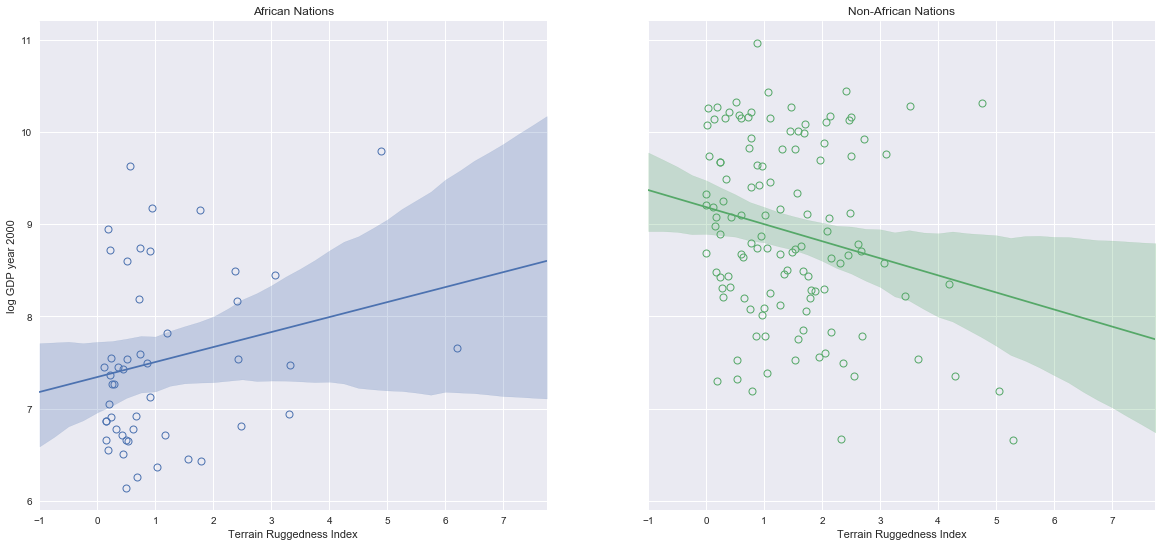

In [16]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)

d_A1 = dd[dd["cont_africa"] == 1]
axs[0].plot(d_A1["rugged"], d_A1["log_gdp"], "o", mew=1, mec="C0", mfc="None")
axs[0].plot(rugged_seq, mu_Africa_mean, color="C0")
axs[0].fill_between(rugged_seq, mu_Africa_pi[:,0], mu_Africa_pi[:,1], alpha=0.25, color="C0")
axs[0].set_title("African Nations")
axs[0].set_xlabel("Terrain Ruggedness Index")

d_A0 = dd[dd["cont_africa"] == 0]
axs[1].plot(d_A0["rugged"], d_A0["log_gdp"], "o", mew=1, mec="C1", mfc="None")
axs[1].plot(rugged_seq, mu_NotAfrica_mean, color="C1")
axs[1].fill_between(rugged_seq, mu_NotAfrica_pi[:,0], mu_NotAfrica_pi[:,1], alpha=0.25, color="C1")
axs[1].set_title("Non-African Nations")
axs[1].set_xlabel("Terrain Ruggedness Index")

axs[0].set_xlim((-1, 7.75))
axs[1].set_xlim((-1, 7.75))
axs[0].set_ylabel("log GDP year 2000");

### 7.12

In [17]:
pm.summary(trace7_5, varnames=["a", "bA", "bR", "bAR", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.184444,0.137387,0.004547,8.922821,9.453004,966.468859,0.999977
bA,-1.842278,0.213761,0.006476,-2.272648,-1.436669,1034.698149,0.999521
bR,-0.185199,0.076231,0.002527,-0.335111,-0.041996,953.940079,0.999554
bAR,0.348174,0.125285,0.004112,0.097962,0.587084,999.895456,0.999516
sigma,0.951450,0.053975,0.001200,0.853771,1.064535,1866.622590,1.001129


### 7.13

In [18]:
gamma_Africa = trace7_5["bR"] + trace7_5["bAR"]*1
gamma_notAfrica = trace7_5["bR"] + trace7_5["bAR"]*0

### 7.14

In [19]:
(gamma_Africa.mean(),
 gamma_notAfrica.mean())

(0.16297436782456265, -0.18519913224527737)

### 7.15

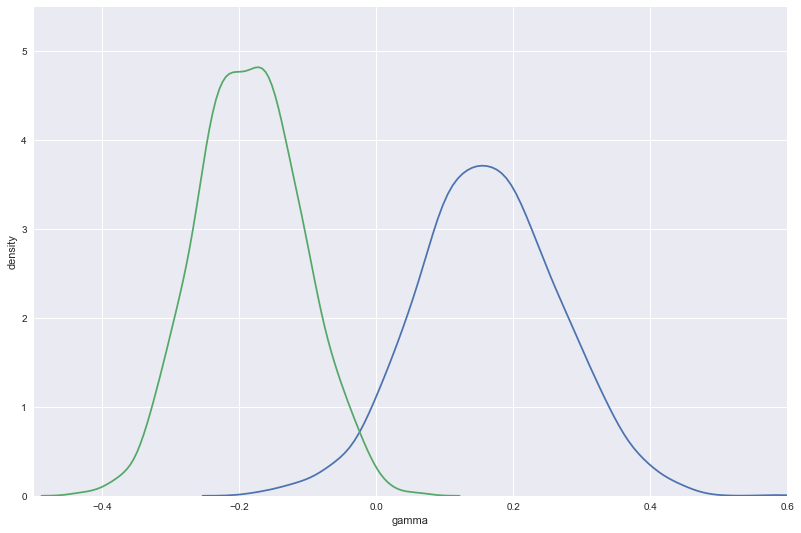

In [20]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(gamma_Africa, ax=ax)
sns.kdeplot(gamma_notAfrica, ax=ax)
ax.set_xlim((-0.5, 0.6))
ax.set_ylim((0, 5.5))
ax.set_xlabel("gamma")
ax.set_ylabel("density");

### 7.16

In [21]:
diff = gamma_Africa - gamma_notAfrica
sum(diff < 0)/len(diff)

0.004

## Symmetry of the Linear Interaction

### 7.17

100%|██████████| 10000/10000 [00:01<00:00, 5451.42it/s]


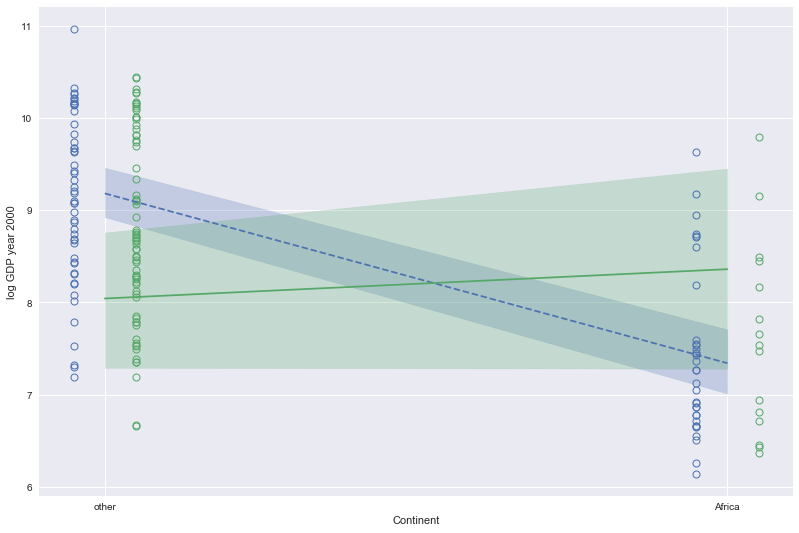

In [22]:
# get minimum and maximum rugged values
q_rugged = (dd["rugged"].min(), dd["rugged"].max())

# compute lines and confidence intervals
model_rugged.set_value(np.repeat(q_rugged[0], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedlo = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedlo_mean = mu_ruggedlo.mean(0)
mu_ruggedlo_pi = pm.hpd(mu_ruggedlo)

model_rugged.set_value(np.repeat(q_rugged[1], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedhi = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedhi_mean = mu_ruggedhi.mean(0)
mu_ruggedhi_pi = pm.hpd(mu_ruggedhi)

# plot it all, splitting points at median
data = (dd
        .assign(more_rugged=lambda df: df["rugged"] > np.median(df["rugged"]))
        .set_index(["more_rugged"]))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(data.loc[False]["cont_africa"] - 0.05, data.loc[False]["log_gdp"], "o", mew=1, mec="C0", mfc="None")
ax.plot(data.loc[True]["cont_africa"] + 0.05, data.loc[True]["log_gdp"], "o", mew=1, mec="C1", mfc="None")

ax.plot([0, 1], mu_ruggedlo_mean, "--", color="C0")
ax.fill_between([0, 1], mu_ruggedlo_pi[:,0], mu_ruggedlo_pi[:,1], alpha=0.25, color="C0")

ax.plot([0, 1], mu_ruggedhi_mean, color="C1")
ax.fill_between([0, 1], mu_ruggedhi_pi[:,0], mu_ruggedhi_pi[:,1], alpha=0.25, color="C1")

ax.set_xlabel("Continent")
ax.set_ylabel("log GDP year 2000")
ax.set_xticks([0, 1])
ax.set_xticklabels(["other", "Africa"]);